### Text Classification

In this notebook we are going create a basic text classifier using the `Naive Bayes` algorithim. We are then going to futher on find the best classification algorithim that will best suit our text classification task.

First thing first we need to install the latest version of `spacy` by running the following command:

In [1]:
!pip install -U spacy==3.* -q

We can check the information about this spacy library by running the following command.

In [2]:
!python -m spacy info

2023-08-16 05:17:21.558475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 05:17:22.845648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

============================== Info about spaCy ==============================

spaCy version    3.6.1                         
Location         /usr/local/lib/python3.10/dist-packages/spacy
Platform         Linux-5.15.109+-x86_64-with-glibc2.35
Python version   3.10.12                       
Pipelines        en_core_web_sm (3.6.0)        



Since we have downloaded `spacy` version `3.*` we must also upgrade the language model `en_core_web_sm`. **`en_core_web_sm`** is a statistical model that we are going to use to process some english sentences. These statistical models can be found at [spacy.io](https://spacy.io/models/en#en_core_web_sm) and they helped us with tokenization, part-of-speech tagging, named entity recognition, etc.

In [3]:
!python -m spacy download en_core_web_sm -q

2023-08-16 05:17:33.649485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 05:17:35.203097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In the following code cell we are going to import all the packages that we are going to use in this notebook.

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

spacy.__version__

'3.6.1'

### Dataset

First thing we need to load the dataset from [20 newsgroup](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset) dataset. In this daset we will get a labeled 18, 000 examples of newsgroup post with `20` topics.

In [5]:
training_corpus = fetch_20newsgroups(subset='train',
                            remove=('headers', 'footers', 'quotes')
                      )
test_corpus = fetch_20newsgroups(subset='test',
                              remove=('headers', 'footers', 'quotes')
                      )

After fetching the `train` and `test` subsets in our dataset we are going to create a validation set from our train data using the `train_test_split` from `sklearn.model_selection`.

In [6]:
SEED = 23

train_data, val_data, train_labels, val_labels = train_test_split(
    training_corpus.data, training_corpus.target,
    train_size=0.8, random_state=SEED)

We can check the size of each subset:

In [7]:
print('Training data size: {}'.format(len(train_data)))
print('Testing data size: {}'.format(len(test_corpus.data)))
print('Validation data size: {}'.format(len(val_data)))

Training data size: 9051
Testing data size: 7532
Validation data size: 2263


We can check the how many unique labels do we have in our dataset in the following code cell.

In [10]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

We can also get the target names in the dataset by calling the `target_names`. Let's check the unique target names in our training_corpus.

In [14]:
set(training_corpus.target_names)

{'alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'}

When starting off with a dataset, it's a good idea to check its distribution. In this case, we can see at a glance this dataset is relatively balanced.In the following code cell we are going to visualize how evenly our labels are in the `train_data`

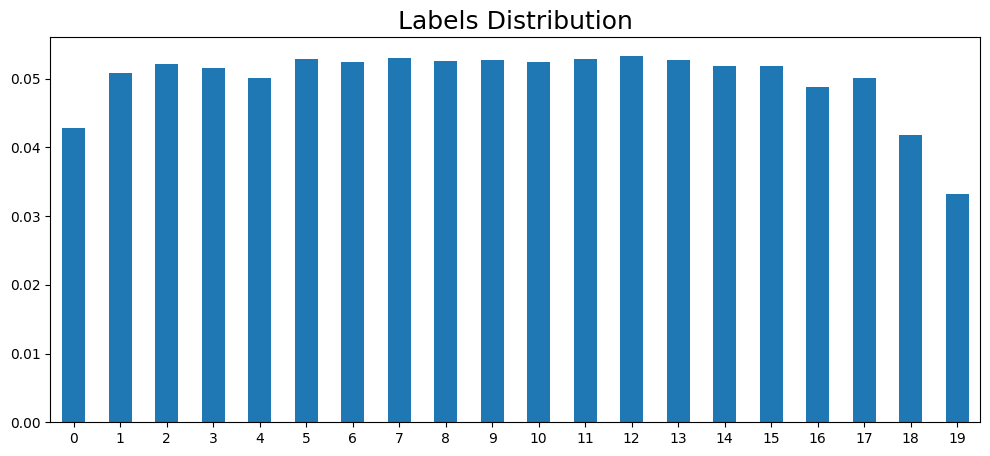

In [13]:
bins, counts = np.unique(train_labels, return_counts=True)
freq_series = pd.Series(counts/len(train_labels))
plt.figure(figsize=(12, 5))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.title("Labels Distribution", fontsize=18)
plt.show()

Let's load the english statistical language model from spacy so that we can create our tokenizer.

In [15]:
nlp = spacy.load('en_core_web_sm')

By default loading the `en_core_web_sm`, comes up with a preprocessing pipeline with several components enabled. We can view these components through the `pipe_names` attribute as follows.

In [16]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

Next we are going to create a tokenizer function that we are going to use as a custom tokenizer function for our `TF-TfidfVectorizer`. Our `spacy_tokenizer` function will do the following as preprocessing steps:

1. remove stop words
2. remove punctuations
3. remove spaces
4. removing alpha numeric
5. lemmatization of words

In [19]:
unwanted_pipes = ['ner', 'parser']
def spacy_tokenizer(sent):
  with nlp.disable_pipes(*unwanted_pipes):
    return [t.lemma_ for t in nlp(sent) if \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop and \
            t.is_alpha]

Let's train the classifier we'll use on the test set. We'll use the entire original training set (including validation data)  Scikit-learn includes a multinomial naive bayes classifier which can be found [here](
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).


We'll also use scikit-learn's `Pipeline` to specify a series of transformation and training steps so we can vectorize and fit a model with one call. Creating a few of these pipelines can help speed up your development and stay organized you can read more about pipelines in sklearn [here](
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).


In [20]:
text_classifier = Pipeline([
  ('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
  ('classifier', MultinomialNB())
])

 Note that the transformations are applied sequentially and we can check the `text_classifer` params by calling the `get_params()` function as follows:

In [21]:
text_classifier.get_params()

{'memory': None,
 'steps': [('vectorizer',
   TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7d87b8284f70>)),
  ('classifier', MultinomialNB())],
 'verbose': False,
 'vectorizer': TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7d87b8284f70>),
 'classifier': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__norm': 'l2',
 'vectorizer__preprocessor': None,
 'vectorizer__smooth_idf': True,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__sublinear_tf': False,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': <function __main__.spacy_tokenizer(sent)>,
 'vectorizer__use_idf'

We can call the `fit` method on the classifier and pass our features and labels as follows.

In [23]:
text_classifier.fit(train_data, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7d87b8284f70>)),
                ('classifier', MultinomialNB())])

We can now pass the raw test data directly to the classifier to make predictions. Let's make predictions using our `test_data`, `train_data` and `val_data`.

In [25]:
test_preds = text_classifier.predict(test_corpus.data)
train_preds = text_classifier.predict(train_data)
val_preds = text_classifier.predict(val_data)

There are a lot of classification metrics that we can use to evaluate our classifier. We are going to evaluate our classifier based on the  `test_data`, `train_data` and `val_data`.


### F1 Score

Let's look at the [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) on the training data. Since the dataset is balanced, accuracy could also work here as well but we'll look at F1 since we introduced it. scikit-learn has a module called [metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) we can leverage. It contains a variety of scoring utilities we can use


In [26]:
test_labels = test_corpus.target

print('Training F1 SCORE: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))
print('Testing F1 SCORE: {}'.format(metrics.f1_score(test_labels, test_preds, average='macro')))
print('Validation F1 SCORE: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))


Training F1 SCORE: 0.8460769516021628
Testing F1 SCORE: 0.6333336998400678
Validation F1 SCORE: 0.6841002853098761


### Confusion Matrix.

In the following code cell we are going to display the [confusion matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix) for our `validation` data using the [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html).


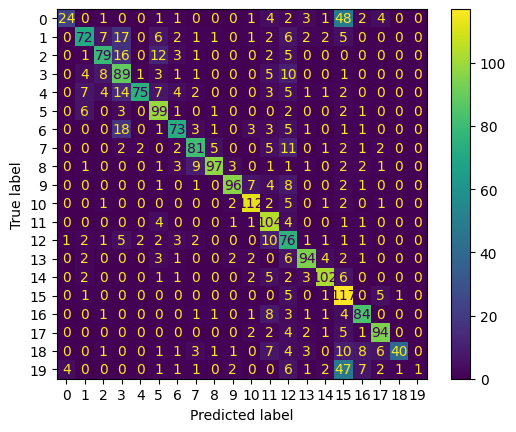

In [33]:
cm = metrics.confusion_matrix(
    val_labels, val_preds
)
ConfusionMatrixDisplay(
   confusion_matrix=cm,
   display_labels=set(val_labels)
).plot()
plt.show()

We can plot a confusion matrix on the train data as follows.

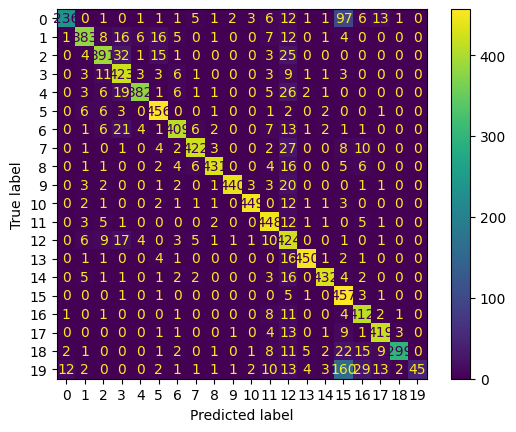

In [34]:
cm = metrics.confusion_matrix(
    train_labels, train_preds
)
ConfusionMatrixDisplay(
   confusion_matrix=cm,
   display_labels=set(train_labels)
).plot()
plt.show()

Bellow is the confusion matrix on the `test_data`

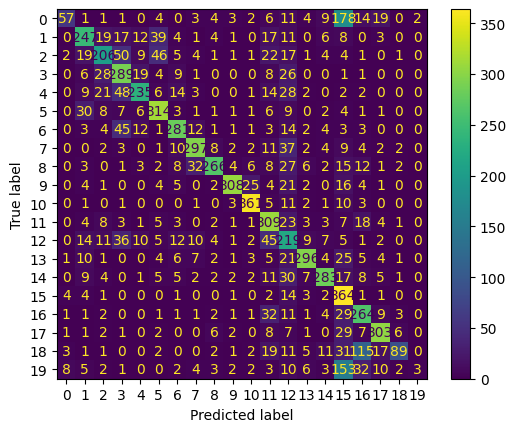

In [35]:
cm = metrics.confusion_matrix(
    test_labels, test_preds
)
ConfusionMatrixDisplay(
   confusion_matrix=cm,
   display_labels=set(test_labels)
).plot()
plt.show()


### Classification Report


We can show the classification report for our predictions on each set, but in this example i will show the classification report based on the `test_data` predictions.

In [38]:
print(metrics.classification_report(test_labels, test_preds, target_names=training_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.74      0.18      0.29       319
           comp.graphics       0.66      0.63      0.65       389
 comp.os.ms-windows.misc       0.64      0.52      0.58       394
comp.sys.ibm.pc.hardware       0.57      0.74      0.65       392
   comp.sys.mac.hardware       0.76      0.61      0.68       385
          comp.windows.x       0.71      0.79      0.75       395
            misc.forsale       0.76      0.72      0.74       390
               rec.autos       0.78      0.75      0.77       396
         rec.motorcycles       0.86      0.67      0.75       398
      rec.sport.baseball       0.92      0.78      0.84       397
        rec.sport.hockey       0.87      0.90      0.89       399
               sci.crypt       0.57      0.78      0.66       396
         sci.electronics       0.39      0.56      0.46       393
                 sci.med       0.84      0.75      0.79       396
         

### Improving the model.

The first thing that we are going to do is to find the best classifier for this task. We are going to manually search the best algorithim that will perform this task better among the following classification algorithms:

1. [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
2. [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
3. [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
4. [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
5. [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)


In [41]:

pipeline_nb =  Pipeline([('nb_classifier',
    Pipeline([
      ('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
      ('classifier', MultinomialNB())
    ])
)])

pipeline_lr =  Pipeline([('lr_classifier',
    Pipeline([
      ('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
      ('classifier', LogisticRegression(random_state=SEED, max_iter=200))
    ])
)])
pipeline_dt =  Pipeline([('dt_classifier',
    Pipeline([
      ('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
      ('classifier', DecisionTreeClassifier(random_state=SEED))
    ])
)])
pipeline_rf =  Pipeline([('rf_classifier',
    Pipeline([
      ('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
      ('classifier',  RandomForestClassifier())
    ])
)])
pipeline_svc =  Pipeline([('svc_classifier',
    Pipeline([
      ('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
      ('classifier', SVC())
    ])
)])
pipelines = [pipeline_nb, pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svc]

pipe_dict = {
   0: "Naive Bayes", 1: 'Logistic Regression', 2: 'Decision Tree', 3: 'RandomForest', 4: "SVC"
}

for pipe in pipelines:
    pipe.fit(val_data, val_labels)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


After training our models we are going to find the best classifier by passing evaluating the algorithm based on the `validation` data and the one that will have bigger `f1-score` is the better algorithm for this task.

In [42]:
cv_results_f1_scores = []
for i, model in enumerate(pipelines):
  preds = model.predict(val_data)
  cv_score = metrics.f1_score(val_labels, preds, average='macro')
  cv_results_f1_scores.append(cv_score)
  print("%s: %f " % (pipe_dict[i], cv_score.mean()))

Naive Bayes: 0.898195 
Logistic Regression: 0.935554 
Decision Tree: 0.976366 
RandomForest: 0.976688 
SVC: 0.975171 


The `RandomForestClassifier` algorithm seems to perform well with a reasonable f1-score of `~98%` we are going to use that to do text classification using this algorithm.


### GridSearchCV

Next, we can try tuning a hyperparameter on the classifier. For `RandomForestClassifier`, we'll adjust the following parameters:

1. criterion

But rather than trying a bunch ourselves, we can use a combination of [`Grid Search`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and `Cross Validation`.

- Grid search involves having the computer try a list of hyperparameter values for us, and returning the best performing value. The list of hyperparameter values to try is supplied by us. [Grid search](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) is a basic technique and there are a number of other techniques such as `random search` and `bayesian optimization`.
- [`Cross validation`](https://scikit-learn.org/stable/modules/cross_validation.html<) is a way to evaluate machine learning models on limited datasets. It randomly splits the data into k-groups. One group is set aside as the holdout set while the classifier trains a model on the remaining groups. The resulting model is then used on the holdout group and the score recorded. This repeats itself until all groups have been used as a holdout set and an average score returned.


In [44]:
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
vectorizer.fit(train_data)
train_vects = vectorizer.transform(train_data)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [47]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss']
}
rf_classifier_grid = model_selection.GridSearchCV(
    RandomForestClassifier(),
    param_grid=params,
    scoring='f1_macro',
    n_jobs=-1,
    cv=5,
    verbose=5
)
rf_classifier_grid.fit(train_vects, train_labels)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss']},
             scoring='f1_macro', verbose=5)

We're interested in the best performing parameter value(s) which we can get as follows:

In [48]:
rf_classifier_grid.best_params_

{'criterion': 'gini'}

We can directly access the best estimator found by the search. Let's try using it on the validation set.

In [49]:
text_classifier = rf_classifier_grid.best_estimator_

val_feature_vects = vectorizer.transform(val_data)
val_preds = text_classifier.predict(val_feature_vects)
print('Validation F1 score with fewer features: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

Validation F1 score with fewer features: 0.6351854847942688


Now we can create a text classifier with the best parameters found using gridsearch.

In [50]:
text_classifier =  Pipeline([
      ('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
      ('classifier',  RandomForestClassifier(
          **rf_classifier_grid.best_params_
      ))
])
text_classifier.fit(train_data, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7d87b8284f70>)),
                ('classifier', RandomForestClassifier())])

We can make predictions on our test data so that we can plot a confusion matrix afterward.

In [51]:
test_preds = text_classifier.predict(test_corpus.data)

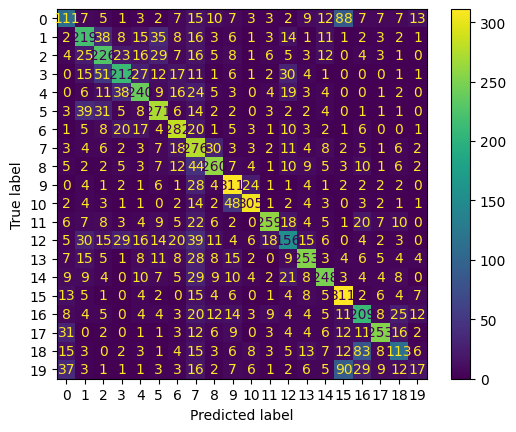

In [52]:
cm = metrics.confusion_matrix(
    test_labels, test_preds
)
ConfusionMatrixDisplay(
   confusion_matrix=cm,
   display_labels=set(test_labels)
).plot()
plt.show()

We can make predictions using our classifier. We will define a function that will classify text.

In [53]:
def classify_text(clf, doc, labels=None):
  probas = clf.predict_proba([doc]).flatten()
  max_proba_idx = np.argmax(probas)
  if labels:
    most_proba_class = labels[max_proba_idx]
  else:
    most_proba_class = max_proba_idx

  return (most_proba_class, probas[max_proba_idx])

In [54]:
# Post from r/medicine.
s = "Hello everyone so am doing my thesis on Ischemic heart disease have been using online articles and textbooks mostly Harrisons internal med. could u recommended me some source specifically books where i can get more about in depth knowledge on IHD."
classify_text(text_classifier, s, training_corpus.target_names)

('sci.med', 0.45625689251254925)

In [55]:
# Post from r/space.
s = "First evidence that water can be created on the lunar surface by Earth's magnetosphere. Particles from Earth can seed the moon with water, implying that other planets could also contribute water to their satellites."
classify_text(text_classifier, s, training_corpus.target_names)

('sci.space', 0.5034489729598861)

In [56]:
# Post from r/cars.
s = "New Toyota 86 Launch Reportedly Delayed to 2022, CEO Doesn't Want a Subaru Copy"
classify_text(text_classifier, s, training_corpus.target_names)

('sci.space', 0.441946024379123)

In [57]:
# Post from r/electronics.
s = "My First Ever Homemade PCB. My SMD Soldering Skills Aren't Great, But I'm Quite Proud of it."
classify_text(text_classifier, s, training_corpus.target_names)

('rec.autos', 0.1268332033127456)

#### Refs

1. https://spacy.io/usage/spacy-101
2. https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics
